In [2]:
import numpy as np
import bm3d
from pathlib import Path
import pickle
from skimage import io, img_as_float
import nibabel as nib
import os
import glob
from collections import defaultdict

File Paths

In [3]:
icip_data = "D:/VIP Cup/Dataset/ICIP training data/"
denoised_pkl_dataset = "D:/VIP Cup/Output dataset/pkl_data"
final_denoised_dataset = "D:/VIP Cup/Output dataset/final_pipeline_denoised_tiff_dataset"


Constants

In [4]:
tiff_directories = defaultdict(int)
denoised_tiff_count = 0
original_tiff_count = 0
SIGMA = 0.085
oct_height = 300
oct_width = 300

Functions to check whether a tiff file/directory or not

In [5]:
def is_tiff_dir(curr_path):
    '''function to check if the current directory having any tiff files'''
    num_tiff = len(glob.glob(os.path.join(curr_path, '*.tiff')))
    return num_tiff

def is_tiff(curr_path):
    '''function to check if the current file is a tiff file or not'''
    if os.path.isfile(curr_path) and (".tiff" in curr_path):
        return True
    else:
        return False

Searching tiff directories

In [6]:
tiff_directories = defaultdict(int)
denoised_tiff_count = 0
original_tiff_count = 0
SIGMA = 0.083

dataset = glob.iglob(os.path.join(icip_data, '**'), recursive=True)

for i,file in enumerate(dataset):
    if is_tiff_dir(file):

        current_tiff_count = is_tiff_dir(file)
        tiff_directories[file] = current_tiff_count
        print(f"{len(tiff_directories)}th case {file} ......")
        original_tiff_count += current_tiff_count



print(f"Denoised cases: {len(tiff_directories)}")
#print(f"Denoised tiff images: {denoised_tiff_count}")
print(f"Original tiff images: {original_tiff_count}")


1th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (1) ......
2th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (10) ......
3th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (11) ......
4th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (12) ......
5th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (13) ......
6th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (14) ......
7th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (15) ......
8th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (16) ......
9th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (17) ......
10th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (18) ......
11th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (19) ......
12th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (2) ......
13th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (20) ......
14th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (21) ......
15t

Denoising Function

In [7]:
import numpy as np
from numpy.linalg import svd
from PIL import Image
import math
import cv2

def get_svd_image(image_path):
    # Open the tiff image

    # Convert the image to a NumPy array
    A = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Remember image size
    n = len(A)

    # Take SVD
    U, S, V = svd(A)

    threshold = 4/np.sqrt(3)
    filter = (S > threshold)*1 
    filtered_S = np.multiply(S, filter)

    # Initialize blank image
    final_img = np.zeros((n, n))
    
    for i in range(n):
        matrix = S[i]*np.outer(U[:,i],V[i])
        final_img += matrix
    
    return final_img

In [23]:
import numpy as np
from numpy.linalg import svd
from PIL import Image
import math

def get_svd_image_from_array(A):

    # Remember image size
    n = len(A)

    # Take SVD
    U, S, V = svd(A)

    threshold = 4/np.sqrt(3)
    filter = (S > threshold)*1 
    filtered_S = np.multiply(S, filter)

    # Initialize blank image
    final_img = np.zeros((n, n))
    
    for i in range(n):
        matrix = S[i]*np.outer(U[:,i],V[i])
        final_img += matrix
    
    return final_img

In [24]:
def open_noisy_image_as_array(image_path):
    image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.array(image_array)

In [43]:
def bm3d_denoise(noisy_image, npsd_sigma = 5):

    noisy_oct = cv2.imread(noisy_image, cv2.IMREAD_GRAYSCALE)
    sigma = npsd_sigma
    bm3d_denoised = bm3d.bm3d(noisy_oct, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return bm3d_denoised

In [52]:
test_path = "D:/VIP Cup/Dataset/ICIP training data/1/RawDataQA-1 (21)/RawDataQA-1-21 (66).tiff"

def find_sigma(test_image):
    
    raw_image = open_noisy_image_as_array(test_image)
    bm3d_denoised_image = bm3d_denoise(test_image)
    cnr, msr = eval_image(bm3d_denoised_image)
    print(f"bmsd denoised_image: CNR: {cnr}, MSR: {msr}")

    import matplotlib.pyplot as plt

    # Plot the noisy raw image
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image, cmap='gray')
    plt.title('Noisy Raw Image')

    # Plot the BM3D denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(bm3d_denoised_image, cmap='gray')
    plt.title('BM3D Denoised Image')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

for sigma in range(1,250,10):
    print(f"sigma: {sigma}")
    find_sigma(test_path)

In [26]:
def bm3d_denoise_from_image_array(noisy_image_array, npsd_sigma = SIGMA):

    sigma = npsd_sigma
    bm3d_denoised = bm3d.bm3d(noisy_image_array, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return bm3d_denoised

Evaluation Metrics

In [27]:
from skimage import exposure as ex
from skimage.filters import threshold_otsu
from skimage.morphology import convex_hull_image
import numpy as np

def get_foreground_background(img, save_folder=None):
    try:
        # Histogram equalization
        h = ex.equalize_hist(img[:,:]) * 255
        
        # Thresholding using Otsu's method on original image
        oi = np.zeros_like(img, dtype=np.uint16)
        oi[(img > threshold_otsu(img))] = 1
        
        # Thresholding using Otsu's method on histogram equalized image
        oh = np.zeros_like(img, dtype=np.uint16)
        oh[(h > threshold_otsu(h))] = 1
        
        # Calculate weights based on the percentage of pixels above Otsu's threshold
        nm = img.shape[0] * img.shape[1]
        w1 = np.sum(oi) / nm
        w2 = np.sum(oh) / nm
        
        # Combine images using weighted sum
        ots = np.zeros_like(img, dtype=np.uint16)
        new = (w1 * img) + (w2 * h)
        ots[(new > threshold_otsu(new))] = 1 
        
        # Compute convex hull of the thresholded image
        conv_hull = convex_hull_image(ots)
        
        # Convert convex hull to binary (0 or 1)
        ch = np.multiply(conv_hull, 1)
        
        # Extract foreground and background images
        fore_image = ch * img
        #print(ch)
        back_image = (1 - ch) * img
    
    except Exception as e:
        print(e)
        fore_image = img.copy()
        back_image = np.zeros_like(img, dtype=np.uint16)
    
    return fore_image,back_image

In [28]:
import numpy as np

def calculate_absolute_cnr(foreground, background):
    # Convert images to float arrays for numerical operations
    foreground = foreground.astype(np.float64)
    background = background.astype(np.float64)
    
    # Calculate mean intensities
    mean_foreground = np.mean(foreground)
    mean_background = np.mean(background)
    
    # Calculate standard deviations
    std_foreground = np.std(foreground)
    std_background = np.std(background)
    
    # Calculate contrast-to-noise ratio (CNR)
    numerator = np.abs(mean_foreground - mean_background)
    denominator = np.sqrt((std_foreground*2 + std_background*2) / 2)
    cnr = numerator / denominator
    
    return cnr

In [29]:
def calculate_msr(data):
    """
    Calculate Mean-to-Standard Deviation Ratio (MSR) of a dataset.

    Parameters:
    - data: NumPy array or list, input dataset

    Returns:
    - msr: float, Mean-to-Standard Deviation Ratio
    """
    # Compute mean and standard deviation of the data
    mean_val = np.mean(data)
    std_dev = np.std(data)
    
    # Calculate MSR (mean-to-standard deviation ratio)
    if std_dev != 0:
        msr = mean_val / std_dev
    else:
        msr = float('inf')  # Handle division by zero case
    
    return msr

In [30]:
def eval_image(image_array):
    # Get foreground and background images
    foreground, background = get_foreground_background(image_array)
    
    # Calculate CNR
    cnr = calculate_absolute_cnr(foreground, background)
    
    # Calculate MSR
    msr = calculate_msr(image_array)
    
    return cnr, msr

Testing evaluation of matrices

In [32]:
raw_image = open_noisy_image_as_array(test_image)
cnr, msr = eval_image(raw_image)
print(f"raw_image: CNR: {cnr}, MSR: {msr}")

bm3d_denoised_image = bm3d_denoise(test_image)
cnr, msr = eval_image(bm3d_denoised_image)
print(f"bmsd denoised_image: CNR: {cnr}, MSR: {msr}")

svd_denoised_image = get_svd_image(test_image)
cnr, msr = eval_image(svd_denoised_image)
print(f"svd denoised_image: CNR: {cnr}, MSR: {msr}")

pipelined_denoised_image = bm3d_denoise_from_image_array(svd_denoised_image)
cnr, msr = eval_image(pipelined_denoised_image)
print(f"pipelined denoised_image: CNR: {cnr}, MSR: {msr}")

final_image = get_svd_image_from_array(bm3d_denoised_image)
cnr, msr = eval_image(final_image)
print(f"final_image: CNR: {cnr}, MSR: {msr}")
final_image

raw_image: CNR: 22.294007851982986, MSR: 4.439450916986934
bmsd denoised_image: CNR: 22.29410862481059, MSR: 4.439500110434538
svd denoised_image: CNR: 22.294007851982986, MSR: 4.439450916986933
pipelined denoised_image: CNR: 22.29410868073923, MSR: 4.4395001311592885
final_image: CNR: 22.294108624810605, MSR: 4.439500110434541


array([[115.00077057, 110.99612427,  92.99911499, ..., 109.99832916,
         88.99729156,  88.99536133],
       [ 95.00112152,  91.00154877,  92.00024414, ...,  96.99783325,
         90.99902344, 108.99979401],
       [ 67.9994812 , 115.00049591,  93.99977875, ...,  84.99729919,
         84.99847412,  90.99512482],
       ...,
       [130.0007782 , 118.99951172, 121.9995575 , ..., 106.99968719,
        114.00144196, 125.99868011],
       [139.99960327,  95.99893951, 121.00043488, ..., 110.00010681,
        113.99971771, 123.00186157],
       [126.00070953, 125.00100708, 122.00067902, ..., 123.00002289,
        126.00232697, 127.99781799]])

In [33]:
final_image.shape

(300, 300)

In [54]:
def bm3d_denoise(noisy_image, npsd_sigma = 5):

    noisy_oct = cv2.imread(noisy_image, cv2.IMREAD_GRAYSCALE)
    sigma = npsd_sigma
    bm3d_denoised = bm3d.bm3d(noisy_oct, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return bm3d_denoised

In [66]:
kif_oct_path = "D:/VIP Cup/Dataset/ICIP training data/1/RawDataQA-1 (21)/RawDataQA-1-21 (66).tiff"

In [67]:
def find_sigma(test_image):
    
    raw_image = open_noisy_image_as_array(test_image)
    bm3d_denoised_image = bm3d_denoise(test_image)
    cnr, msr = eval_image(bm3d_denoised_image)
    print(f"bmsd denoised_image: CNR: {cnr}, MSR: {msr}")

    import matplotlib.pyplot as plt

    # Plot the noisy raw image
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image, cmap='gray')
    plt.title('Noisy Raw Image')

    # Plot the BM3D denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(bm3d_denoised_image, cmap='gray')
    plt.title('BM3D Denoised Image')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [69]:
for sigma in range(1,250,10):
    print(f"sigma: {sigma}")
    find_sigma(kif_oct_path)

sigma: 1


TypeError: Can't convert object to 'str' for 'filename'

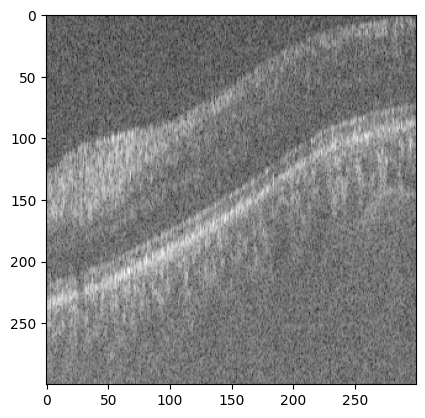

In [34]:
import matplotlib.pyplot as plt

plt.imshow(raw_image, cmap='gray')

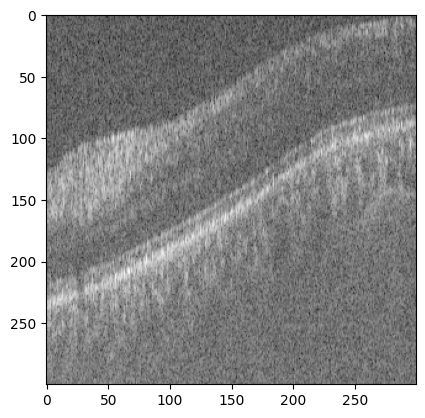

In [35]:
plt.imshow(bm3d_denoised_image, cmap='gray')

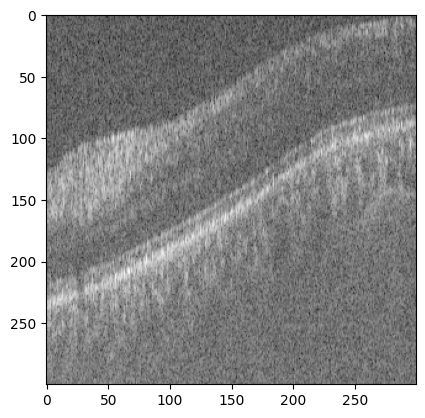

In [36]:
plt.imshow(final_image, cmap='gray')

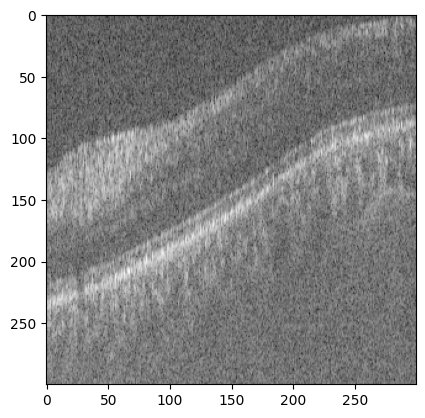

In [37]:
plt.imshow(pipelined_denoised_image, cmap='gray')

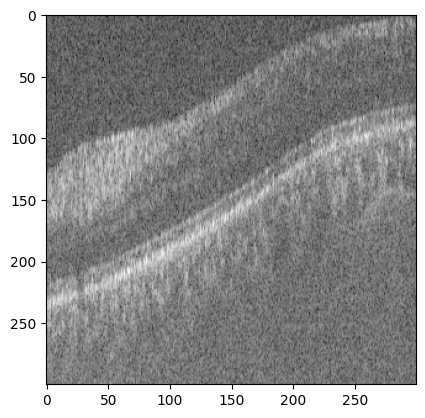

In [38]:
plt.imshow(svd_denoised_image, cmap='gray')

Saving Denoised Image as a .tiff file

In [23]:
def save_denoised_image_as_tiff(denoised_array, output_path):
    
    plt.imsave(output_path, denoised_array, cmap='gray')

Output path generating function

In [24]:
def generate_out_path(file, output_dir, sigma):
    '''generate output path'''
    file_name = os.path.basename(file).split(".")[0]
    case_name = os.path.basename(os.path.dirname(file))
    class_name = os.path.basename(os.path.dirname(os.path.dirname(file)))

    case_dir = os.path.join(output_dir,class_name,case_name)
    os.makedirs(case_dir, exist_ok=True)

    out_path = os.path.join(case_dir, file_name + "_denoised_.tiff")
    return out_path

Denoising Function

In [27]:
#denoising function
def denoise(image_path, output_path, sigma=SIGMA):
    '''function to denoise the image'''
    bm3d_denoised = bm3d_denoise(image_path, sigma)
    svd_denoised = get_svd_image_from_array(bm3d_denoised)
    save_denoised_image_as_tiff(svd_denoised, output_path)

In [28]:
tiff_directories

defaultdict(int,
            {'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (1)': 52,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (10)': 273,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (11)': 300,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (12)': 258,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (13)': 146,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (14)': 220,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (15)': 87,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (16)': 52,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (17)': 176,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (18)': 300,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (19)': 84,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (2)': 201,
             'D:/VIP Cup/Dataset/ICIP training data\\

Denoising Pipeline

In [29]:
# denoising pipeline for denoise the tiff images in each and every tiff directories
def denoising_pipeline(tiff_directories, final_denoised_dataset, SIGMA):
    '''denoising pipeline for denoise the tiff images in each and every tiff directories'''
    count = 0

    for i, tiff_dir in enumerate(tiff_directories):
        print(f"{i}th case {tiff_dir} ......")

        tiff_files = os.listdir(tiff_dir)

        if len(tiff_files) == tiff_directories[tiff_dir]:
            for tiff_file in tiff_files:
                tiff_file_path = os.path.join(tiff_dir, tiff_file)
                output_path = generate_out_path(tiff_file_path, final_denoised_dataset, SIGMA)
                denoise(tiff_file_path, output_path, SIGMA)
        else:
            raise Exception(f"Number of tiff files in the directory is not equal to the number of tiff files in the dictionary in {tiff_dir}")

        print(f"{i}th case {tiff_dir} denoised ......")
        count += 1

    return count
count = 0

In [30]:
# denoising pipeline for denoise the tiff images in each and every tiff directories
denoised_tiff_count = denoising_pipeline(tiff_directories, final_denoised_dataset, SIGMA)
print(f"Denoised cases: {denoised_tiff_count}")

0th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (1) ......
0th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (1) denoised ......
1th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (10) ......
1th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (10) denoised ......
2th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (11) ......
2th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (11) denoised ......
3th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (12) ......
3th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (12) denoised ......
4th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (13) ......
4th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (13) denoised ......
5th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (14) ......
5th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (14) denoised ......
6th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (15) ......
6th case D:/VIP Cup/Datas